## Script for Figure 3a 

In this script, a fully expanded C3 source leaf is modelled and flux through mitochondrial ATP synthase is observed to generate Figure 3a

In [1]:
#import functions from library
from libsbml import readSBML
from cobra import io,flux_analysis
import re
from cobra.core import Metabolite, Reaction
from studyFunctions import *

#import model. Update file name and location in the next line
cobra_model = io.sbml.create_cobra_model_from_sbml_file("core_model.xml")

#set up a diel model, allow for day-night metabolite accumulations and constrain model to represent C3 leaf diel metabolism
cobra_model=setupDielModel(cobra_model,"MetabolitesToTransfer.txt")

0.5 CIT_v1 + 0.5 aCIT_v1 <=> 0.5 CIT_v2 + 0.5 aCIT_v2
0.7 MAL_v1 + 0.3 aMAL_v1 <=> 0.7 MAL_v2 + 0.3 aMAL_v2
bHIS_v1 --> bHIS_v2


##### Increase upper and lower bounds to 2000 and -2000 respectively in order to allow for PPFD upto 1500

In [2]:
for rxn in cobra_model.reactions:
    if rxn.lower_bound < -999:
        rxn.lower_bound = -2000
    if rxn.upper_bound > 999:
        rxn.upper_bound = 2000

In [3]:
phloem_model = cobra_model.copy()

### Constrain the model output so that net CO2 uptake matches experimental data for the chosen light input value (200 PPFD)


    Data extracted Fig 3 of Donahue et al 1997, see Script1.py.

In [4]:
"""
x = light, y = net CO2 uptake
y = a + bx + c^2"""
a = 0.0871351015562
b = 0.0291441670197
c = -0.000009013134

light=list()
CO2=list()
for x in range(100,1550,50):
    light.append(x)
    y=((a)+(b*x)+(c*(x**2)))
    CO2.append(y)
    
light_CO2=dict(zip(light, CO2))

import pandas as pd
df = pd.DataFrame(data={"PPFD":light,"Net CO2 uptake":CO2})
df = df[["PPFD","Net CO2 uptake"]]

    Model flux distribution based on CO2 assimilation rate

In [5]:
WTphloemOut = dict()
solutiondict_phloem = dict()
PPFD_list=list()

for i in range(100,1550,50):
    PPFD = i
    tempModel2 = phloem_model.copy()
    tempModel2.reactions.get_by_id("Photon_tx1").upper_bound = PPFD*0.9
    tempModel2.reactions.get_by_id("Photon_tx1").lower_bound = PPFD*0.9
    tempModel2.reactions.get_by_id("ATPase_tx1").upper_bound = estimateMaintenance(200)
    tempModel2.reactions.get_by_id("ATPase_tx1").lower_bound = estimateMaintenance(200)
    solution=flux_analysis.parsimonious.pfba(tempModel2)
    WTphloemOut[PPFD] = estimateOutputFromNetCO2(tempModel2,light_CO2[PPFD],verbose=False)
    tempModel2.reactions.get_by_id("diel_biomass").upper_bound = round(WTphloemOut[PPFD],3)
    tempModel2.reactions.get_by_id("diel_biomass").lower_bound = round(WTphloemOut[PPFD],3)
    solution=flux_analysis.parsimonious.pfba(tempModel2)
    solutiondict_phloem[PPFD]=solution.x_dict
    PPFD_list.append(i)


    Generate Fig 3a

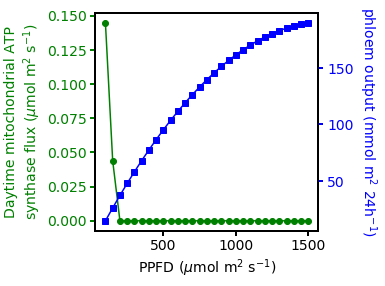

In [6]:

xlist = list()
ylist1 = list()
ylist2 = list()
for PPFD in PPFD_list:
    xlist.append(PPFD)
    ylist1.append(solutiondict_phloem[PPFD]["Mitochondrial_ATP_Synthase_m1"])
    ylist2.append(WTphloemOut[PPFD]*4/1000*60*60*24)




import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.rcParams.update({'font.size': 14}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['axes.linewidth']=2 # makes axes line thicker

import pandas as pd
import numpy as np

fig, ax1 = plt.subplots(figsize=(4, 4))

ax1.plot(xlist,ylist1,"go-")
ax1.set_xlabel("PPFD ($\mu$mol m$^2$ s$^{-1}$)")
ax1.set_ylabel("Daytime mitochondrial ATP\nsynthase flux ($\mu$mol m$^2$ s$^{-1}$)",color="g")
ax1.tick_params("y",colors="g")

ax2 = ax1.twinx()
ax2.plot(xlist,ylist2,"bs-")
ax2.set_ylabel("phloem output (mmol m$^2$ 24h$^{-1}$)",color="b",rotation='270')
ax2.yaxis.set_label_coords(1.27,0.5)
ax2.tick_params("y",colors="b")

#fig.tight_layout()
plt.show()

##### Perform pFBA and FVA and write results to file

In [192]:
WTphloemOut = dict()
solutiondict_phloem = dict()
FVAdict_phloem = dict()
PPFD_list=list()

for i in range(100,1550,50):
    PPFD = i
    print("Running PPFD = "+str(i))
    tempModel2 = phloem_model.copy()
    tempModel2.reactions.get_by_id("Photon_tx1").upper_bound = PPFD*0.9
    tempModel2.reactions.get_by_id("Photon_tx1").lower_bound = PPFD*0.9
    tempModel2.reactions.get_by_id("ATPase_tx1").upper_bound = estimateMaintenance(200)
    tempModel2.reactions.get_by_id("ATPase_tx1").lower_bound = estimateMaintenance(200)
    solution=flux_analysis.parsimonious.pfba(tempModel2)
    WTphloemOut[PPFD] = estimateOutputFromNetCO2(tempModel2,light_CO2[PPFD],verbose=False)
    tempModel2.reactions.get_by_id("diel_biomass").upper_bound = round(WTphloemOut[PPFD],3)
    tempModel2.reactions.get_by_id("diel_biomass").lower_bound = round(WTphloemOut[PPFD],3)
    solution=flux_analysis.parsimonious.pfba(tempModel2)
    solutiondict_phloem[PPFD]=solution.x_dict
    PPFD_list.append(i)
    
    fva_result = flux_analysis.flux_variability_analysis(tempModel2,fraction_of_optimum=1)
    FVAdict_phloem[PPFD] = fva_result
    

printFluxesAndFVA(tempModel2,solutiondict_phloem,FVAdict_phloem,outfile="Fluxes_Source_Leaf.csv")
print("Done")

Running PPFD = 100
Running PPFD = 150
Running PPFD = 200
Running PPFD = 250
Running PPFD = 300
Running PPFD = 350
Running PPFD = 400
Running PPFD = 450
Running PPFD = 500
Running PPFD = 550
Running PPFD = 600
Running PPFD = 650
Running PPFD = 700
Running PPFD = 750
Running PPFD = 800
Running PPFD = 850
Running PPFD = 900
Running PPFD = 950
Running PPFD = 1000
Running PPFD = 1050
Running PPFD = 1100
Running PPFD = 1150
Running PPFD = 1200
Running PPFD = 1250
Running PPFD = 1300
Running PPFD = 1350
Running PPFD = 1400
Running PPFD = 1450
Running PPFD = 1500
